# LSTM Sample Implementation

In [1]:
import glob
from models import DataReader
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()


print('Tensorflow Version: {}'.format(tf.__version__))

Tensorflow Version: 1.8.0


## Data load

In [2]:
DIR = '/home/miles/PycharmProjects/MultivariateTimeSeries/data/'
dr = DataReader(
    directory=DIR,
    coin='dgb',
    batch_size=100,
    train_size=0.9)
training_batches = dr.get_batch(is_training=True)
testing_batches = dr.get_batch(is_training=False)

# Network Implementation

## Constants

In [3]:
TIME_STEPS = 28
N_INPUT = 5
N_HIDDEN = 128
LEARNING_RATE = 0.001
NUM_UNITS = 28

tf.reset_default_graph()

In [4]:
# Input placeholders
x = tf.placeholder(tf.float32, [None, TIME_STEPS, N_INPUT])
y = tf.placeholder(tf.float32, [None, 1])

In [5]:
out_weights = tf.Variable(tf.random_normal([NUM_UNITS, 1]))
out_bias = tf.Variable(tf.random_normal([1]))

In [6]:
# Reshape the input tensor from [batch_size, timesteps, n_input] to
# "timesteps" of [batch_size, n_input]
unstacked_inputs = tf.unstack(x, TIME_STEPS, 1)

In [9]:
lstm_layer = tf.contrib.rnn.BasicLSTMCell(NUM_UNITS, forget_bias=1)
outputs, _ = tf.contrib.rnn.static_rnn(lstm_layer, unstacked_inputs, dtype=tf.float32) 

In [10]:
predictions = tf.matmul(outputs[-1], out_weights) + out_bias

In [11]:
loss = tf.losses.mean_squared_error(y, predictions)
train_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_batch = next(testing_batches)

    for step in range(10001):
        train_batch = next(training_batches)
        features = train_batch.get('features')
        targets = train_batch.get('targets')
        feed_dict = {x: features, y: targets}
        
        sess.run(train_step, feed_dict=feed_dict)
        
        if step % 1000 == 0:
            mse = sess.run(loss, feed_dict=feed_dict)
            print(f'Step={step}, Training Loss={mse}')
            
        #if step % 2000 == 0:
        #    features = test_batch.get('features')
        #    targets = test_batch.get('targets')
        #    feed_dict = {x: features, y: targets}
        #    p = sess.run(loss, feed_dict=feed_dict)
        #    print(f'\tStep={step}, Testing Loss={mse}')
            
    #batch = next(testing_batches)
    features = test_batch.get('features')
    targets = test_batch.get('targets')
    feed_dict = {x: features, y: targets}
    p = sess.run(predictions, feed_dict=feed_dict)

            

Step=0, Training Loss=0.006705880165100098
Step=1000, Training Loss=4.691610229201615e-05
Step=2000, Training Loss=4.5151788071962073e-05
Step=3000, Training Loss=0.00015918788267299533
Step=4000, Training Loss=3.787518653552979e-05
Step=5000, Training Loss=4.8516671085963026e-05
Step=6000, Training Loss=0.0001628676982363686
Step=7000, Training Loss=4.862024434260093e-05
Step=8000, Training Loss=7.800976891303435e-05
Step=9000, Training Loss=5.394444815465249e-05
Step=10000, Training Loss=7.753744284855202e-05


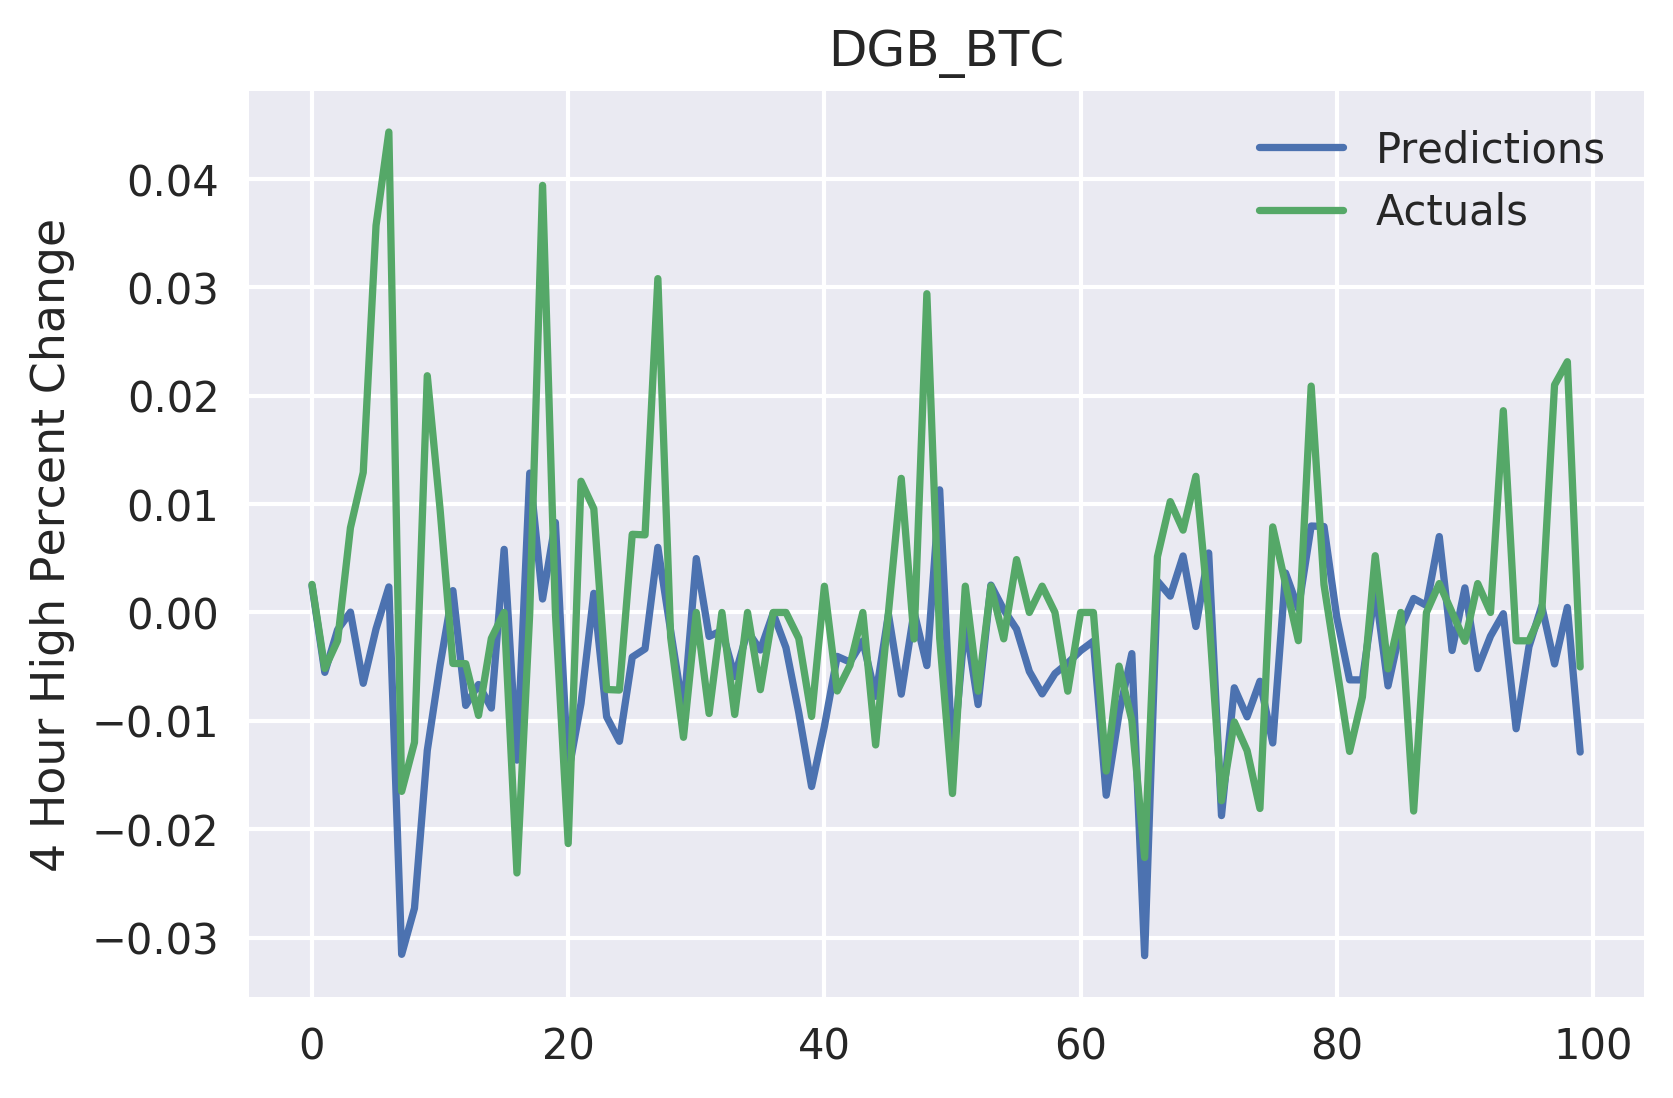

In [13]:
fig, ax = plt.subplots()
fig.set_dpi(300)
ax.plot(p.flatten(), label='Predictions')
ax.plot(targets.flatten(), label='Actuals')
ax.legend()
ax.set_title(dr.coin)
ax.set_ylabel('4 Hour High Percent Change')
plt.show()

fig.savefig('/tmp/dgb_btc_high_predictions.png')

/home/miles/miniconda3/envs/MultivariateTimeSeries/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


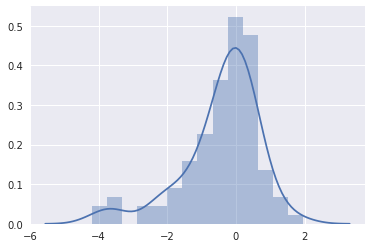

In [14]:
residuals = (p.flatten() - targets.flatten())

fig, ax = plt.subplots()
sns.distplot((p.flatten() - targets.flatten())* 100, ax=ax)

plt.show()


In [ ]:
np.std(residuals* 100)

In [ ]:
np.mean(residuals*100)

In [ ]:
sns.regplot(targets.flatten(), p.flatten())